In [1]:
#import
import scipy.io as sio
import scipy.stats
import numpy as np
import cv2
import matplotlib.pyplot as plt
from Project1.EM_help_functions_update import * 

iter 0: 0.004987001419067383
iter 1: 0.0009970664978027344
iter 2: 0.0009975433349609375
iter 3: 0.0
iter 4: 0.0009975433349609375
iter 5: 0.0
iter 6: 0.0009970664978027344
iter 7: 0.0
iter 8: 0.0
iter 9: 0.000997304916381836
iter 10: 0.0009980201721191406
iter 11: 0.0009970664978027344
iter 12: 0.0009975433349609375
iter 13: 0.0
iter 14: 0.0
iter 15: 0.0009970664978027344
iter 16: 0.000997304916381836
iter 17: 0.0
iter 18: 0.0009975433349609375
iter 19: 0.0009980201721191406


In [2]:
#Load image  
img = cv2.imread('D:\\OneDrive\\OneDrive - National University of Singapore\\Year 1- Semester 2\\CS5340 Uncertainty Modeling in AI\\CS5340_Project_files\\191003 Assignment Instructions\\CS5340_Project_files\\Project1\\P1080055.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
sobelx = cv2.Sobel(img_gray,cv2.CV_64F,1,0)
sobely = cv2.Sobel(img_gray,cv2.CV_64F,0,1)
Gmag_ = np.sqrt(sobelx**2.0 + sobely**2.0)
Gdir_ = np.arctan2(sobely, sobelx)
Gdir, idx = down_sample(Gmag_, Gdir_)

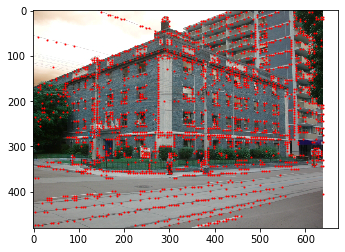

In [3]:
#Plot the downsmapled points in picture
im=plt.imshow(img)    
plt.scatter(y=idx[:,0]*5+4,x=idx[:,1]*5+4,s=1,color="red")
plt.show()

In [4]:
def homo2img_coord(x):
    u=x[0]/x[2]
    v=x[1]/x[2]
    return np.array([u,v])
def img2homo_coord(x):
    return np.array(x[0],x[1],1.)
def pro_mixture(a, b, g):
    '''
    :param a, b, g_: camera rotation parameters
    :return: p_image
    '''

    R = angle2matrix(a, b, g) # Convert the angles into rotation matrix
    p_image = 0.0   # initial posterior setting to zero
    

    P_ang=np.zeros(shape=(idx.shape[0],4))
    for i in range(idx.shape[0]):
        #Pixel Location    
        p=np.array([idx[i,1]*5+4,idx[i,0]*5+4,1],dtype=float)
        #Theta and phi (pixel gradient)
        Theta=vp2dir(K, R, p)
        phi=Gdir[idx[i,0],idx[i,1]]
        error=remove_polarity(phi-Theta)
        #P ang
        P_ang[i,:3]=np.nan_to_num(scipy.stats.norm(mu, sig).pdf(error))
        P_ang[i,3]=1/(2.0*np.pi)
        #Evidence
    p_image = np.sum(np.nan_to_num(np.log(P_ang.dot(np.array(P_m_prior)))))
                    
    # to be implemented, to compute the posterior of the gaussian mixture model, which is equation (6) in the manhattan paper

    return p_image   

In [5]:
beta = np.linspace(-np.pi/3, np.pi/3, 60)
P = np.zeros_like(beta)

for k in range(beta.shape[0]):
    a = 0.0
    b = beta[k]
    g = 0.0
    P[k] = pro_mixture(a, b, g)
idx_coarse = np.argsort(P)
b_opt = beta[idx_coarse[-1]]

search_range = [-1.0, 0.0, 1.0]
R_list = []
P_list = np.zeros([len(search_range)**3,])
c = 0
for i in range(len(search_range)):
    b = b_opt + (np.pi)/90 * search_range[i]
    for j in range(len(search_range)):
        a = (np.pi)/36 * search_range[j]
        for k in range(len(search_range)):
            g = (np.pi) / 36 * search_range[k]
            R_list.append([a, b, g])
            P_list[c] = pro_mixture(a, b, g)
            c += 1
idx_fine1 = np.argsort(P_list)
R_opt = R_list[idx_fine1[-1]]

search_range = [-2.0, -1.0, 0.0, 1.0, 2.0]
R_list = []
P_list = np.zeros([len(search_range)**2,])
c = 0
b = R_opt[1]
for i in range(len(search_range)):
    a = R_opt[0] + np.pi/36 * search_range[i]
    for j in range(len(search_range)):
        g = R_opt[2] + np.pi/36 * search_range[j]
        R_list.append([a, b, g])
        P_list[c] = pro_mixture(a, b, g)
        c += 1
idx_fine2 = np.argsort(P_list)
R_opt = R_list[idx_fine2[-1]]

In [6]:
#To visualize Vanishing point location
R_opt1 = angle2matrix(R_opt[0],R_opt[1],R_opt[2])
vp_loc=K.dot(R_opt1).dot(vp_dir)
vp1=homo2img_coord(vp_loc[:,0])
vp2=homo2img_coord(vp_loc[:,1])
vp3=homo2img_coord(vp_loc[:,2])
print(vp1)
print(vp2)
print(vp3)

[1013.1019   251.45424]
[  953.16656 10926.985  ]
[-338.06396  333.1676 ]


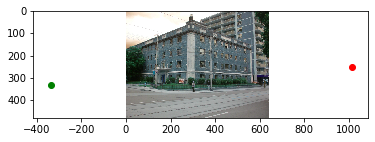

In [7]:
#Plot the vanishing points in picture
im=plt.imshow(img)    
plt.scatter(y=vp1[1],x=vp1[0],color='red')
plt.scatter(y=vp3[1],x=vp3[0],color='green')
plt.show()

In [8]:
def E_step(S):
    '''
    :param S : the Cayley-Gibbs-Rodrigu representation of camera rotation parameters
    :return: w_pm
    '''
    R = vector2matrix(S)  # Note that the 'S' is just for optimization, it has to be converted to R during computation
    w_pm = np.zeros([idx.shape[0], 4], dtype=np.float32)
    
    P_ang=np.zeros(shape=(idx.shape[0],4))
    # to be implemented, the E-step to compute the weights for each vanishing point at each pixel
    for i in range(idx.shape[0]):
        #Pixel Location    
        p=np.array([idx[i,1]*5+4,idx[i,0]*5+4,1],dtype=float)
        #Theta and phi (pixel gradient)
        Theta=vp2dir(K, R, p)
        phi=Gdir[idx[i,0],idx[i,1]]
        error=remove_polarity(phi-Theta)
        #P ang
        P_ang[i,:3]=np.nan_to_num(scipy.stats.norm(mu, sig).pdf(error))
        P_ang[i,3]=1/(2.0*np.pi)
    P_ang=P_ang*(np.array(P_m_prior))
    w_pm=P_ang
    Z_p=np.sum(w_pm,axis=1)
    Z_p=np.repeat(np.array((1./Z_p)), repeats=4).reshape((idx.shape[0],4))
    w_pm=w_pm*Z_p
    return w_pm

def M_step(S0, w_pm):
    '''
    :param S0 : the camera rotation parameters from the previous step
    :param w_pm : weights from E-step
    :return: R_m : the optimized camera rotation matrix
    '''
    S_m = least_squares(error_fun, S0, args= (w_pm,))

    return S_m

def error_fun(S, w_pm):

    '''
    :param c : the variable we are going to optimize over
    :param w_pm : weights from E-step
    :return: error : the error we are going to minimize
    '''

    error = 0.0    # initial error setting to zero
    R = vector2matrix(S) # Note that the 'S' is just for optimization, it has to be converted to R during computation
    
    # to be implemented, the error function to be minimized by the M-setp.
    Weighted_Least_Sq=np.zeros(shape=(idx.shape[0],))
    for i in range(idx.shape[0]):
        #Pixel Location    
        p=np.array([idx[i,1]*5+4,idx[i,0]*5+4,1],dtype=float)
        #Theta and phi (pixel gradient)
        Theta=vp2dir(K, R, p)
        phi=Gdir[idx[i,0],idx[i,1]]
        error=remove_polarity(phi-Theta)
        error=remove_polarity(error**2)
        w_pm_temp=w_pm[i,:3]      
        #Weighted Least Square
        Weighted_Least_Sq[i]=w_pm_temp.dot(error)
    error=np.sum(Weighted_Least_Sq)
    print("Error: ", error)
    print("S: ", S)
    vp_loc=K.dot(R).dot(vp_dir)
    vp1=homo2img_coord(vp_loc[:,0])
    vp2=homo2img_coord(vp_loc[:,1])
    vp3=homo2img_coord(vp_loc[:,2])
    print("VP Location 1: ",vp1)
    print("VP Location 3: ",vp3)
    return error


In [9]:
#EM Algorithm
num_iter = 20
R = angle2matrix(R_opt[0], R_opt[1], R_opt[2])
S = matrix2vector(R)
for i in range(num_iter):
    t = time()
    w_pm = E_step(S)
    opt = M_step(S, w_pm)
    S = opt.x
    print('iter {}: {}'.format(i, time()-t))
R_em = vector2matrix(S)


Error:  185.764194598742
S:  [-0.00704165 -0.40191839 -0.01754814]
VP Location 1:  [1011.10776303  226.74681234]
VP Location 3:  [-339.09730646  274.13803218]
Error:  185.7641932165061
S:  [-0.00704166 -0.40191839 -0.01754814]
VP Location 1:  [1011.10776275  226.74682241]
VP Location 3:  [-339.0973062   274.13805617]
Error:  185.76419463034676
S:  [-0.00704165 -0.40191841 -0.01754814]
VP Location 1:  [1011.1077269   226.74681343]
VP Location 3:  [-339.09733967  274.13803292]
Error:  185.76419489937877
S:  [-0.00704165 -0.40191839 -0.01754815]
VP Location 1:  [1011.10776241  226.74678733]
VP Location 3:  [-339.09730588  274.1380418 ]
Error:  480.4886332317209
S:  [-0.40011418 -0.3929308   0.06794527]
VP Location 1:  [1231.21002127  666.95196005]
VP Location 3:  [-514.1606897   981.82450489]
Error:  208.09365775158085
S:  [-0.10530978 -0.39967149  0.00382522]
VP Location 1:  [1027.09619902  329.06749949]
VP Location 3:  [-343.73072393  420.3995132 ]
Error:  185.4001961412377
S:  [-0.0316

Error:  185.05743352787766
S:  [-0.02145469 -0.40081886 -0.01394865]
VP Location 1:  [1013.91163636  242.45371286]
VP Location 3:  [-336.76951086  294.96279075]
Error:  185.05743352722655
S:  [-0.02145469 -0.40081884 -0.01394867]
VP Location 1:  [1013.91167174  242.45368692]
VP Location 3:  [-336.76947689  294.96279939]
Error:  185.05743341826337
S:  [-0.02145561 -0.4008191  -0.01395157]
VP Location 1:  [1013.91087812  242.44943355]
VP Location 3:  [-336.76989601  294.96615715]
Error:  185.05743341817515
S:  [-0.02145562 -0.4008191  -0.01395157]
VP Location 1:  [1013.91087829  242.4494436 ]
VP Location 3:  [-336.76989616  294.96618115]
Error:  185.05743341818726
S:  [-0.02145561 -0.40081912 -0.01395157]
VP Location 1:  [1013.91084183  242.44943442]
VP Location 3:  [-336.76992915  294.9661581 ]
Error:  185.05743341797023
S:  [-0.02145561 -0.4008191  -0.01395158]
VP Location 1:  [1013.91087721  242.44940848]
VP Location 3:  [-336.76989517  294.96616673]
iter 0: 11.287697315216064
Error: 

Error:  184.41555964056948
S:  [-0.02662264 -0.40243955 -0.01266957]
VP Location 1:  [1010.14866578  248.17735844]
VP Location 3:  [-340.53926981  302.58134227]
Error:  184.41555963986013
S:  [-0.02662265 -0.40243955 -0.01266957]
VP Location 1:  [1010.14866611  248.17736849]
VP Location 3:  [-340.53927012  302.58136633]
Error:  184.4155596396828
S:  [-0.02662264 -0.40243956 -0.01266957]
VP Location 1:  [1010.14862974  248.17735923]
VP Location 3:  [-340.53930311  302.5813433 ]
Error:  184.41555963854296
S:  [-0.02662264 -0.40243955 -0.01266959]
VP Location 1:  [1010.14866477  248.17733348]
VP Location 3:  [-340.53926888  302.58135191]
Error:  184.4155590304194
S:  [-0.02663012 -0.40244891 -0.01269096]
VP Location 1:  [1010.12475513  248.1470712 ]
VP Location 3:  [-340.55899709  302.60792135]
Error:  184.4155590309619
S:  [-0.02663014 -0.40244891 -0.01269096]
VP Location 1:  [1010.12475546  248.14708125]
VP Location 3:  [-340.5589974   302.60794541]
Error:  184.4155590296393
S:  [-0.026

Error:  184.24672088468333
S:  [-0.02849758 -0.40355992 -0.01217177]
VP Location 1:  [1007.52535958  250.33253002]
VP Location 3:  [-343.1210825   305.36796194]
Error:  184.2467208843284
S:  [-0.02849757 -0.40355993 -0.01217177]
VP Location 1:  [1007.52532331  250.33252072]
VP Location 3:  [-343.12111554  305.36793891]
Error:  184.246720883369
S:  [-0.02849757 -0.40355992 -0.01217179]
VP Location 1:  [1007.52535815  250.33249507]
VP Location 3:  [-343.12108117  305.36794752]
Error:  184.24672063030184
S:  [-0.02850419 -0.40357049 -0.01219301]
VP Location 1:  [1007.49860578  250.30203895]
VP Location 3:  [-343.14356274  305.3932087 ]
Error:  184.24672063122844
S:  [-0.02850421 -0.40357049 -0.01219301]
VP Location 1:  [1007.49860618  250.302049  ]
VP Location 3:  [-343.14356311  305.3932328 ]
Error:  184.24672062949668
S:  [-0.02850419 -0.4035705  -0.01219301]
VP Location 1:  [1007.49856991  250.30203971]
VP Location 3:  [-343.14359614  305.39320977]
Error:  184.24672063295378
S:  [-0.02

Error:  184.1873094590619
S:  [-0.02923209 -0.40426292 -0.01193301]
VP Location 1:  [1005.87228833  251.26147792]
VP Location 3:  [-344.73277962  306.45179938]
Error:  184.18730945949181
S:  [-0.02923209 -0.40426291 -0.01193302]
VP Location 1:  [1005.87232305  251.26145233]
VP Location 3:  [-344.73274518  306.451808  ]
Error:  184.18730882262582
S:  [-0.02922481 -0.40428411 -0.01194339]
VP Location 1:  [1005.82050069  251.24029485]
VP Location 3:  [-344.77948938  306.44831253]
Error:  184.18730882220407
S:  [-0.02922482 -0.40428411 -0.01194339]
VP Location 1:  [1005.82050111  251.24030489]
VP Location 3:  [-344.77948977  306.44833665]
Error:  184.18730882233422
S:  [-0.02922481 -0.40428412 -0.01194339]
VP Location 1:  [1005.82046492  251.24029558]
VP Location 3:  [-344.77952285  306.44831361]
Error:  184.18730882343385
S:  [-0.02922481 -0.40428411 -0.01194341]
VP Location 1:  [1005.82049964  251.24026999]
VP Location 3:  [-344.7794884   306.44832224]
iter 3: 8.703728675842285
Error:  1

Error:  184.14601543141302
S:  [-0.0294941  -0.40462002 -0.01179975]
VP Location 1:  [1005.03266417  251.67781266]
VP Location 3:  [-345.55094069  306.81510071]
Error:  184.14601544566716
S:  [-0.0294941  -0.40462    -0.01179977]
VP Location 1:  [1005.03269883  251.67778711]
VP Location 3:  [-345.5509062   306.81510934]
Error:  529.6915828733469
S:  [-0.29233568 -0.5435806   0.26448043]
VP Location 1:  [828.67444094 864.31035837]
VP Location 3:  [-908.84633377  542.51552603]
Error:  218.23614953173822
S:  [-0.09520449 -0.43936015  0.05727029]
VP Location 1:  [939.64108385 405.59744713]
VP Location 3:  [-441.87450778  369.46224269]
Error:  186.2690320478218
S:  [-0.0459217  -0.41330504  0.00546776]
VP Location 1:  [986.67669994 291.40061447]
VP Location 3:  [-367.37664003  322.71083294]
Error:  184.27381869697183
S:  [-0.033601   -0.40679126 -0.00748288]
VP Location 1:  [1000.30091598  261.7107846 ]
VP Location 3:  [-350.87271741  310.80372056]
Error:  184.1528858338882
S:  [-0.03052083

Error:  184.1397129441134
S:  [-0.02963095 -0.40482111 -0.01170223]
VP Location 1:  [1004.56176451  251.94231112]
VP Location 3:  [-346.01330497  306.98773905]
Error:  184.13971294451994
S:  [-0.02963096 -0.40482111 -0.01170223]
VP Location 1:  [1004.56176494  251.94232117]
VP Location 3:  [-346.01330538  306.98776319]
Error:  184.13971294337455
S:  [-0.02963095 -0.40482112 -0.01170223]
VP Location 1:  [1004.56172883  251.94231184]
VP Location 3:  [-346.01333849  306.98774014]
Error:  184.13971294435567
S:  [-0.02963095 -0.40482111 -0.01170225]
VP Location 1:  [1004.56176346  251.9422863 ]
VP Location 3:  [-346.01330399  306.98774878]
Error:  184.13971278200114
S:  [-0.02961946 -0.40484198 -0.01169539]
VP Location 1:  [1004.51194206  251.94697085]
VP Location 3:  [-346.06038129  306.96619218]
Error:  184.13971278104236
S:  [-0.02961948 -0.40484198 -0.01169539]
VP Location 1:  [1004.5119425  251.9469809]
VP Location 3:  [-346.0603817   306.96621632]
Error:  184.1397127819465
S:  [-0.029

Error:  184.13524218650167
S:  [-0.02964758 -0.40487518 -0.01167813]
VP Location 1:  [1004.4344791   251.99627611]
VP Location 3:  [-346.13699043  307.00288037]
Error:  184.1352421864898
S:  [-0.02964759 -0.40487518 -0.01167813]
VP Location 1:  [1004.43447953  251.99628616]
VP Location 3:  [-346.13699084  307.00290451]
Error:  184.13524218599423
S:  [-0.02964758 -0.4048752  -0.01167813]
VP Location 1:  [1004.43444342  251.99627683]
VP Location 3:  [-346.13702395  307.00288145]
Error:  184.13524218650662
S:  [-0.02964758 -0.40487518 -0.01167814]
VP Location 1:  [1004.43447805  251.99625129]
VP Location 3:  [-346.13698944  307.00289009]
Error:  371.97755954939606
S:  [-0.03915282 -0.81087181 -0.0077214 ]
VP Location 1:  [450.64322606 271.44492593]
VP Location 3:  [-2900.93043657   431.21628075]
Error:  194.93277329128392
S:  [-0.03202389 -0.50637434 -0.01068895]
VP Location 1:  [803.36483004 258.8160621 ]
VP Location 3:  [-612.17991208  319.49640356]
Error:  184.74150867747707
S:  [-0.03

Error:  184.13492316560368
S:  [-0.02964918 -0.40490056 -0.01167725]
VP Location 1:  [1004.37383418  252.00004784]
VP Location 3:  [-346.19418504  307.00674983]
Error:  184.13492316559814
S:  [-0.02964918 -0.40490054 -0.01167726]
VP Location 1:  [1004.3738688   252.00002231]
VP Location 3:  [-346.19415053  307.00675847]
iter 11: 4.293519496917725
Error:  184.13491725801845
S:  [-0.02964918 -0.40490054 -0.01167725]
VP Location 1:  [1004.37386985  252.00004713]
VP Location 3:  [-346.19415152  307.00674874]
Error:  184.13491725801794
S:  [-0.0296492  -0.40490054 -0.01167725]
VP Location 1:  [1004.37387029  252.00005717]
VP Location 3:  [-346.19415193  307.00677288]
Error:  184.1349172580144
S:  [-0.02964918 -0.40490056 -0.01167725]
VP Location 1:  [1004.37383418  252.00004784]
VP Location 3:  [-346.19418504  307.00674983]
Error:  184.13491725801774
S:  [-0.02964918 -0.40490054 -0.01167726]
VP Location 1:  [1004.3738688   252.00002231]
VP Location 3:  [-346.19415053  307.00675847]
Error:  

Error:  184.13492629410558
S:  [-0.02965727 -0.40499916 -0.01166918]
VP Location 1:  [1004.13865669  252.02366934]
VP Location 3:  [-346.41679459  307.02174964]
Error:  184.13491686435353
S:  [-0.02965121 -0.40492529 -0.01167523]
VP Location 1:  [1004.31484973  252.00595695]
VP Location 3:  [-346.25000192  307.01051995]
Error:  184.13491627679122
S:  [-0.0296497  -0.40490682 -0.01167675]
VP Location 1:  [1004.35890662  252.00152808]
VP Location 3:  [-346.20830887  307.00771267]
Error:  184.13491624051602
S:  [-0.02964932 -0.4049022  -0.01167712]
VP Location 1:  [1004.36992138  252.00042082]
VP Location 3:  [-346.19788592  307.00701086]
Error:  184.1349162383607
S:  [-0.02964923 -0.40490105 -0.01167722]
VP Location 1:  [1004.3726751  252.000144 ]
VP Location 3:  [-346.19528021  307.00683541]
Error:  184.13491623825394
S:  [-0.0296492  -0.40490076 -0.01167724]
VP Location 1:  [1004.37336353  252.00007479]
VP Location 3:  [-346.19462878  307.00679154]
Error:  184.13491623825422
S:  [-0.02

Error:  184.13491567849067
S:  [-0.0296492  -0.40490074 -0.01167723]
VP Location 1:  [1004.37339372  252.00009019]
VP Location 3:  [-346.19460167  307.00678197]
Error:  184.13491567848808
S:  [-0.0296492  -0.40490074 -0.01167725]
VP Location 1:  [1004.37339364  252.000059  ]
VP Location 3:  [-346.19459927  307.00679123]
Error:  184.1349156784879
S:  [-0.0296492  -0.40490074 -0.01167726]
VP Location 1:  [1004.37339362  252.00005121]
VP Location 3:  [-346.19459867  307.00679354]
iter 16: 4.556333303451538
Error:  184.13491567848789
S:  [-0.0296492  -0.40490074 -0.01167726]
VP Location 1:  [1004.37339361  252.00004861]
VP Location 3:  [-346.19459847  307.00679431]
Error:  184.1349156784878
S:  [-0.02964921 -0.40490074 -0.01167726]
VP Location 1:  [1004.37339405  252.00005866]
VP Location 3:  [-346.19459888  307.00681845]
Error:  184.13491567848786
S:  [-0.0296492  -0.40490076 -0.01167726]
VP Location 1:  [1004.37335794  252.00004933]
VP Location 3:  [-346.19463199  307.0067954 ]
Error:  1

Error:  184.13496388397445
S:  [-0.02965766 -0.40490357 -0.0115785 ]
VP Location 1:  [1004.37383589  252.17036939]
VP Location 3:  [-346.20771001  306.95624706]
Error:  184.13491856002355
S:  [-0.02965131 -0.40490145 -0.01165257]
VP Location 1:  [1004.37350543  252.0426288 ]
VP Location 3:  [-346.19787751  306.99415776]
Error:  184.13491585858867
S:  [-0.02964973 -0.40490092 -0.01167108]
VP Location 1:  [1004.37342165  252.01069366]
VP Location 3:  [-346.1954183   307.00363519]
Error:  184.1349156897453
S:  [-0.02964933 -0.40490079 -0.01167571]
VP Location 1:  [1004.37340063  252.00270987]
VP Location 3:  [-346.19480343  307.00600453]
Error:  184.13491567919175
S:  [-0.02964923 -0.40490075 -0.01167687]
VP Location 1:  [1004.37339537  252.00071392]
VP Location 3:  [-346.19464971  307.00659687]
Error:  184.13491567853197
S:  [-0.02964921 -0.40490075 -0.01167716]
VP Location 1:  [1004.37339405  252.00021494]
VP Location 3:  [-346.19461128  307.00674495]
Error:  184.13491567849067
S:  [-0.

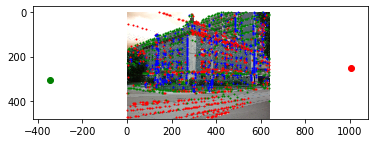

In [10]:
#Plot Downsampled pixel along with its VP
im=plt.imshow(img)
argmax_vp=np.argmax(w_pm,axis=1)
for i in range(idx.shape[0]):
    if argmax_vp[i]==0:
        plt.scatter(y=idx[i,0]*5,x=idx[i,1]*5,color='red',s=1)
    elif argmax_vp[i]==1:
        plt.scatter(y=idx[i,0]*5,x=idx[i,1]*5,color='blue',s=1)
    elif argmax_vp[i]==2:
        plt.scatter(y=idx[i,0]*5,x=idx[i,1]*5,color='green',s=1)
    elif argmax_vp[i]==3:
        pass
        #plt.scatter(y=idx[i,0]*5,x=idx[i,1]*5,color='red',s=1)

vp_loc=K.dot(R_em).dot(vp_dir)
vp1=homo2img_coord(vp_loc[:,0])
vp2=homo2img_coord(vp_loc[:,1])
vp3=homo2img_coord(vp_loc[:,2])
 
plt.scatter(y=vp3[1],x=vp3[0],color='green')
plt.scatter(y=vp1[1],x=vp1[0],color='red')
#plt.show()
plt.savefig("P1080055-Result.png", dpi=300)

In [15]:
print(vp1)
print(vp2)
print(vp3)

[1004.37339361  252.00004861]
[  -333.81643141 -15495.9003478 ]
[-346.19459847  307.00679431]


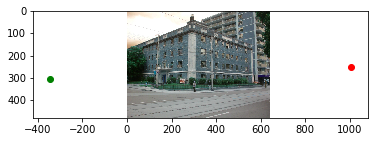

In [11]:
#Plot VP Location
im=plt.imshow(img)

vp_loc=K.dot(R_em).dot(vp_dir)
vp1=homo2img_coord(vp_loc[:,0])
vp2=homo2img_coord(vp_loc[:,1])
vp3=homo2img_coord(vp_loc[:,2])
 
plt.scatter(y=vp3[1],x=vp3[0],color='green')
plt.scatter(y=vp1[1],x=vp1[0],color='red')
#plt.show()
plt.savefig("P1080055-VPloc.png", dpi=300)

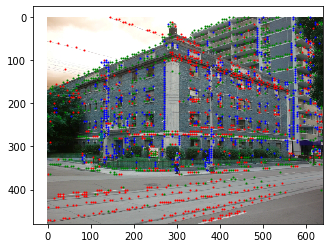

In [12]:
#Plot Downsampled pixel along with its Assignment
im=plt.imshow(img)
argmax_vp=np.argmax(w_pm,axis=1)
for i in range(idx.shape[0]):
    if argmax_vp[i]==0:
        plt.scatter(y=idx[i,0]*5,x=idx[i,1]*5,color='red',s=1)
    elif argmax_vp[i]==1:
        plt.scatter(y=idx[i,0]*5,x=idx[i,1]*5,color='blue',s=1)
    elif argmax_vp[i]==2:
        plt.scatter(y=idx[i,0]*5,x=idx[i,1]*5,color='green',s=1)
    elif argmax_vp[i]==3:
        pass
plt.savefig("P1080055-Assignment.png", dpi=300)